# Forecasting 


### Notebook Content

### Multivariate Time Series
1. Multivariate-Time-Series
2. Multivariate-fbprophet

# Multivariate Time Series – VAR

A Multivariate time series has more than one time-dependent variable. Each variable depends not only on its past values but also has some dependency on other variables.<br>
Consider the above example. Now suppose our dataset includes perspiration percent, dew point, wind speed, cloud cover percentage, etc. along with the temperature value for the past two years. In this case, there are multiple variables to be considered to optimally predict temperature. A series like this would fall under the category of multivariate time series. Below is an illustration of this:
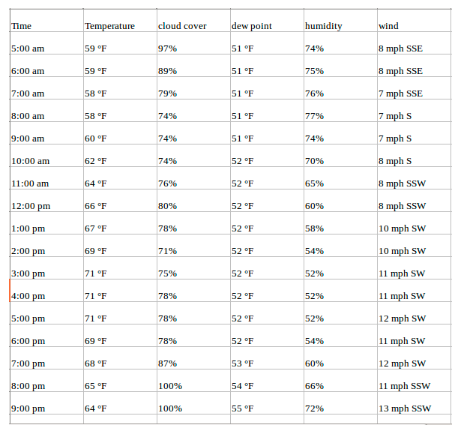


Now that we understand what a multivariate time series looks like, let us understand how can we use it to build a forecast.

**Dealing with a Multivariate Time Series – VAR**
In this section, I will introduce you to one of the most commonly used methods for multivariate time series forecasting – Vector Auto Regression (VAR).

In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables.<br>
for further unnderstanding for theory:https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

In [171]:
df = pd.read_excel("dataset/AirQualityUCI.xlsx",parse_dates = [['Date','Time']])

In [172]:
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

In [173]:
#missing value treatment
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
        if data[j][i] == -200:
            data[j][i] = data[j][i-1]

#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = data.drop([ 'CO(GT)'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([1.75628733e-01, 1.52399674e-01, 1.15090998e-01, 1.04309966e-01,
       9.29562919e-02, 6.90255307e-02, 5.76654697e-02, 3.43596700e-02,
       3.06350634e-02, 1.18801270e-02, 2.46819409e-03, 7.09473977e-05])

In [174]:
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [175]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]


In [176]:
#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[2.34562472e+00 1.08604049e+03 2.80752383e+02 1.24358835e+01
  1.05542000e+03 2.81217778e+02 6.59528135e+02 1.68188388e+02
  1.15845997e+03 8.50834322e+02 2.73623551e+01 1.55617864e+01
  5.15356506e-01]]


In [177]:
yhat[0]

array([2.34562472e+00, 1.08604049e+03, 2.80752383e+02, 1.24358835e+01,
       1.05542000e+03, 2.81217778e+02, 6.59528135e+02, 1.68188388e+02,
       1.15845997e+03, 8.50834322e+02, 2.73623551e+01, 1.55617864e+01,
       5.15356506e-01])

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Forecasting" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>


# Multivariate fbprophet

In [178]:
# for simplicity we have incorporated only one column
regressor_columns = ['ds']

# Defining final forecast dataframe
final_forecast = pd.DataFrame([])

In [179]:
for date in training_months:

    train_set = master_data.loc[master_data['ds'] < date,]

    test_regressor_data = master_data[regressor_columns]
    test_prophet_features = test_regressor_data.loc[test_regressor_data['ds']>=date,]

    # defining the model
    # Since it is monthly dataset, we can add seasonality only from quarterly
    m = Prophet(daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False)\
            .add_country_holidays(country_name=Country)\
            .add_seasonality(name="Yearly", period=365.25, fourier_order=10)\
            .add_seasonality(name='half_yearly', period=365.25/2, fourier_order=10)\
            .add_seasonality(name='Quaterly', period=365.25/4, fourier_order=10)\


    ## Model Fit
    m.fit(train_set)

    ## Making future dataframes
    year = year_valid_start
    day = 1
    month = int(date[5:7])
    month1 = 1
    year1 = year_valid_end

    # Creating test dataframes
    test_prophet = m.make_future_dataframe(periods= forecasting_period , 
                                           freq='M', include_history=False)
    test_prophet['ds'] =  test_prophet['ds'] + timedelta(days=1)
    test_prophet['Month'] = test_prophet['ds'].apply(lambda x: x.month)
    
    # Appending the external regressors to the test dataframe
    test_prophet = test_prophet.merge(test_prophet_features, how='left', on='ds')

    # Forecasting results with the regressors
    forecast_prophet = m.predict(test_prophet)

    test_pred_prophet = forecast_prophet
    test_prophet['Prophet_Predictions'] = test_pred_prophet['yhat'].tolist()

    test_prophet = test_prophet.merge(master_data[['ds','y']], how='left', on='ds')

    final_forecast = pd.concat([final_forecast, test_prophet])

In [180]:
final_forecast.shape

(12, 4)

In [181]:
data = data_1.copy()

Text(0,0.5,'Number of Passengers')

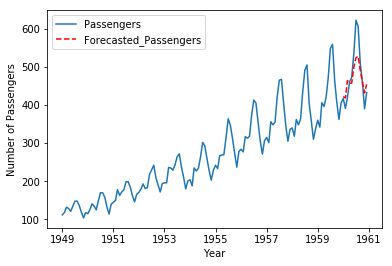

In [183]:
plt.plot(data)
test = data.iloc[132:]

test['forecast'] = final_forecast['Prophet_Predictions'].values
plt.plot(test['forecast'], color = 'red',ls = 'dashed')
plt.legend(["Passengers","Forecasted_Passengers"])
plt.xlabel('Year')
plt.ylabel('Number of Passengers')

In [184]:
print('Mean Absolute percentage Error:', mape(data[132:]['Passengers'],test['forecast']))  
print('Mean Squared Error:', metrics.mean_squared_error(test['forecast'], data[132:]))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test['forecast'], data[132:])))

Mean Absolute percentage Error: 6.467467043948577
Mean Squared Error: 1887.8212395652056
Root Mean Squared Error: 43.44906488712048


<a class="list-group-item list-group-item-action" data-toggle="list" href="#Forecasting" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>


# ARIMAX-SARIMAX
An Autoregressive Integrated Moving Average with Explanatory Variable (ARIMAX) model can be viewed as a multiple regression model with one or more autoregressive (AR) terms and/or one or more moving average (MA) terms. This method is suitable for forecasting when data is stationary/non stationary, and multivariate with any type of data pattern

In [7]:
df = pd.read_excel("dataset/AirQualityUCI.xlsx",parse_dates = [['Date','Time']])

In [8]:
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

In [9]:
#missing value treatment
data = data.replace(to_replace=-200,value = np.NaN)
cols = data.columns
for j in cols:
    data[j] = data[j].fillna(method = 'ffill')
    data[j] = data[j].fillna(method = 'bfill')

In [10]:
# Lets make CO(GT) as our target variable, which we will try forecast 
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

X_train,Y_train = train.drop(['CO(GT)'],axis =  1), train['CO(GT)']
X_test,Y_test = valid.drop(['CO(GT)'],axis =  1), valid['CO(GT)']

In [11]:
from pmdarima.arima import auto_arima

In [14]:
model = auto_arima(y = Y_train,exogenous = X_train, start_p=1, start_q=0, max_p=1, max_q=1, m=24,max_P=1,d=1,
    max_D=1,max_Q=1,start_P=1, seasonal=True, trace=True,
                      error_action='ignore', 
                      suppress_warnings=True,
                      stepwise=True,n_jobs=7)  

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=4966.431, Time=242.87 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=5515.600, Time=8.27 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=5047.486, Time=250.63 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=5122.117, Time=488.70 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=5514.478, Time=42.96 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=5151.704, Time=124.09 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=5489.743, Time=11.34 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=5018.121, Time=229.10 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=4995.084, Time=263.49 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=4942.290, Time=343.03 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=5030.022, Time=298.73 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=5475.986, Time=28.14 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=4940.981, Time=324.26 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=5128.503, Time=166.32 

In [15]:
prediction = model.predict(n_periods= len(Y_test),exogenous=X_test)

In [18]:
print('Mean Absolute percentage Error:', mape(Y_test,prediction))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test,prediction))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test,prediction)))

Mean Absolute percentage Error: 49.08492813338224
Mean Squared Error: 0.4020662136862746
Root Mean Squared Error: 0.6340869133535832
